In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

df = pd.read_excel('tp_2020conference.xlsx', sheet_name='tp_2020conference', engine='openpyxl')

### Step 1:

In this step, we filter the papers into two groups — accepted and rejected — based on their review scores. By filtering papers into two categories — accepted (rate ≥ 6) and rejected (rate < 6) — we can separate high-quality submissions from those that didn’t meet the acceptance criteria. This is a common data-cleaning and filtering step, aimed at preparing the dataset for further analysis — such as understanding trends in successful submissions or identifying common patterns among rejected papers.

In [2]:
accepted = df[df['rate'] >= 6]
rejected = df[df['rate'] < 6]

In [3]:
print("Accepted papers:")
print(accepted['title'].to_string(index=False))

Accepted papers:
Carpe Diem, Seize the Samples Uncertain *at the...
Prestopping: How Does Early Stopping Help Gener...
Analysis and Interpretation of Deep CNN Represe...
Improving Evolutionary Strategies with Generati...
Improving Evolutionary Strategies with Generati...
Improving Evolutionary Strategies with Generati...
Wide Neural Networks are Interpolating Kernel M...
SSE-PT: Sequential Recommendation Via Personali...
SSE-PT: Sequential Recommendation Via Personali...
Scoring-Aggregating-Planning: Learning task-agn...
Scoring-Aggregating-Planning: Learning task-agn...
Star-Convexity in Non-Negative Matrix Factoriza...
Noise Regularization for Conditional Density Es...
Neural Maximum Common Subgraph Detection with G...
When Does Self-supervision Improve Few-shot Lea...
Deep Reasoning Networks: Thinking Fast and Slow...
Stochastically Controlled Compositional Gradien...
Probabilistic modeling the hidden layers of dee...
Probabilistic modeling the hidden layers of dee...
Probabilistic 

In [4]:
print("Rejected papers:")
print(rejected['title'].to_string(index=False))

Rejected papers:
Carpe Diem, Seize the Samples Uncertain *at the...
Carpe Diem, Seize the Samples Uncertain *at the...
Prestopping: How Does Early Stopping Help Gener...
Prestopping: How Does Early Stopping Help Gener...
Prestopping: How Does Early Stopping Help Gener...
Analysis and Interpretation of Deep CNN Represe...
Analysis and Interpretation of Deep CNN Represe...
Analysis and Interpretation of Deep CNN Represe...
Wide Neural Networks are Interpolating Kernel M...
Wide Neural Networks are Interpolating Kernel M...
Wide Neural Networks are Interpolating Kernel M...
SSE-PT: Sequential Recommendation Via Personali...
Scoring-Aggregating-Planning: Learning task-agn...
Count-guided Weakly Supervised Localization Bas...
Count-guided Weakly Supervised Localization Bas...
Count-guided Weakly Supervised Localization Bas...
Star-Convexity in Non-Negative Matrix Factoriza...
Star-Convexity in Non-Negative Matrix Factoriza...
Noise Regularization for Conditional Density Es...
Noise Regulari

### Step 2:

Clustering the keywords in this dataset allows us to identify underlying research themes across a large number of academic papers without manually reading each one. By grouping papers with similar keyword sets, we can uncover dominant topics, understand how research areas are distributed, and spot patterns in the kinds of work that tend to be accepted or rejected. This step is especially useful for researchers who want to explore trends, identify niche or emerging topics, or filter papers by subject area — ultimately making it easier to navigate large-scale academic datasets and support informed decision-making in research analysis or paper recommendations.

In [5]:
# Replace NaN with empty strings (if any)
df['keyword'] = df['keyword'].fillna('')

# Remove duplicates (if any)
df = df.drop_duplicates(subset=['keyword'])

# Converting keywords into TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(df['keyword'])

# Applying K-means clustering
num_clusters = 10 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Adding clustering results to the table
df['cluster'] = kmeans.labels_

# Reviewing the result
print("Clustered Data:")
print(df[['keyword', 'cluster']])

# Unique clusters
print("\nUnique clusters:")
print(df['cluster'].value_counts())

Clustered Data:
                                                keyword  cluster
0     Keywords:###batch selection, uncertain sample,...        9
3     Keywords:###noisy label, label noise, robustne...        9
7     Keywords:###interpretation, perceptual quality...        9
11    Keywords:###black-box optimization, evolutiona...        9
14    Keywords:###overparametrization, generalizatio...        9
...                                                 ...      ...
7751  Keywords:###Neural Processes, Deep Sets, Trans...        9
7754  Keywords:###margin, homogeneous, gradient descent        9
7757  Keywords:###adversarial examples, adversarial ...        8
7760  Keywords:###Question Answering, Multi-Hop QA, ...        9
7763                     Keywords:###federated learning        3

[2270 rows x 2 columns]

Unique clusters:
cluster
9    915
3    354
0    263
8    183
1    144
6    125
5    124
2     76
7     53
4     33
Name: count, dtype: int64


In [6]:
# Get cluster centers
centroids = kmeans.cluster_centers_

# Get the words that have the most influence on each cluster
terms = tfidf_vectorizer.get_feature_names_out()

# For each cluster find the 10 most significant words
for i in range(num_clusters):
    print(f"Cluster {i}:")
    cluster_centroid = centroids[i]
    top_terms_idx = cluster_centroid.argsort()[-10:][::-1]
    top_terms = [terms[idx] for idx in top_terms_idx]
    print(", ".join(top_terms))
    print("\n")

Cluster 0:
reinforcement, learning, keywords, deep, policy, imitation, multi, exploration, agent, model


Cluster 1:
graph, networks, neural, keywords, learning, network, representation, convolutional, knowledge, classification


Cluster 2:
machine, learning, translation, keywords, neural, security, language, deep, sequence, comprehension


Cluster 3:
learning, deep, keywords, meta, representation, shot, supervised, optimization, self, networks


Cluster 4:
continual, learning, catastrophic, forgetting, lifelong, keywords, variational, meta, deep, task


Cluster 5:
models, generative, variational, inference, keywords, autoencoder, learning, generation, autoencoders, video


Cluster 6:
model, compression, keywords, network, language, quantization, neural, deep, learning, based


Cluster 7:
search, architecture, neural, keywords, automl, network, learning, tree, nas, optimization


Cluster 8:
adversarial, robustness, examples, keywords, generative, attack, networks, learning, defense, at

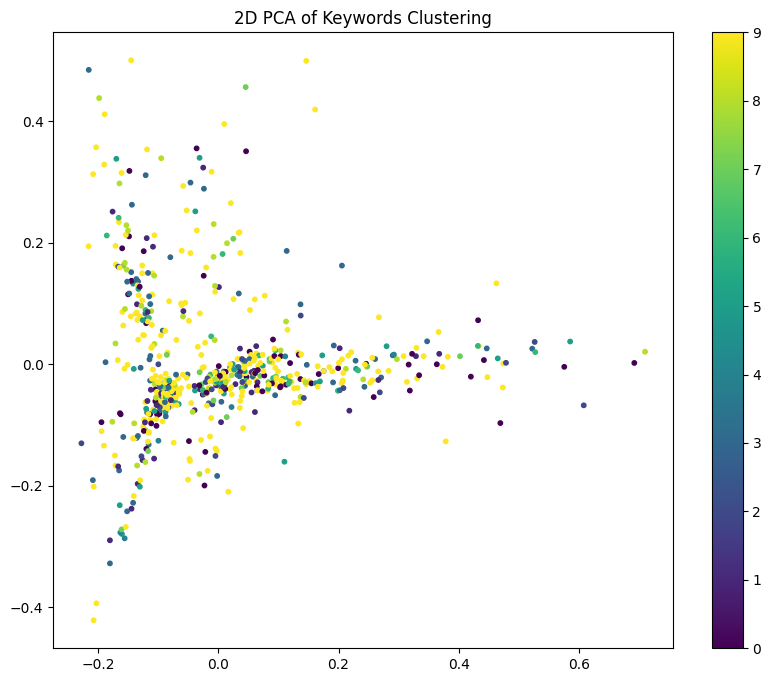

In [7]:
# Apply PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X.toarray())

# Add clusters to the result
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = df['cluster']

plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['cluster'], cmap='viridis', s=10)
plt.colorbar()
plt.title('2D PCA of Keywords Clustering')
plt.show()

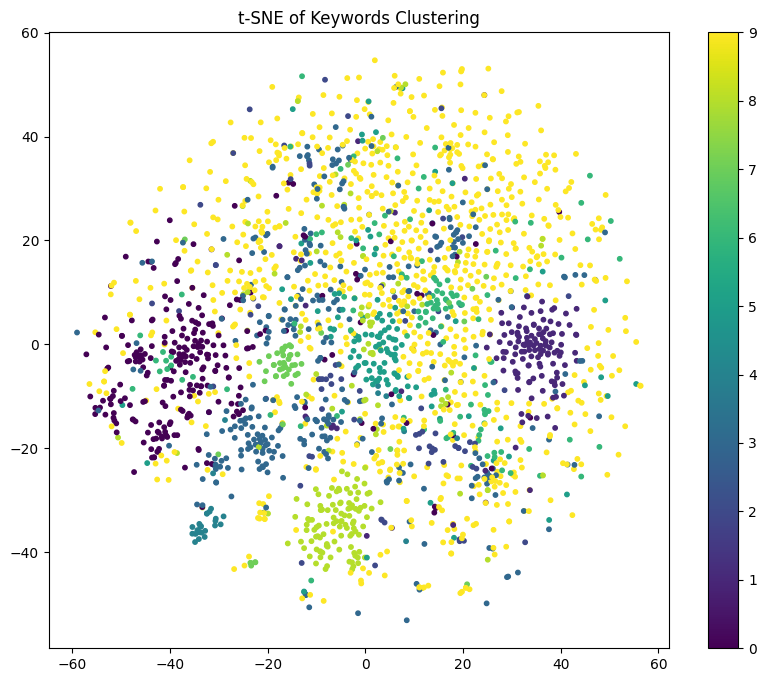

In [8]:
# Apply t-SNE to reduce the dimensionality to 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['cluster'], cmap='viridis', s=10)
plt.colorbar()
plt.title('t-SNE of Keywords Clustering')
plt.show()

### Step 3:

This step of sampling random papers from each cluster serves as a way to validate the clustering and check if the groups make sense. It provides an initial understanding of what each cluster represents, which is crucial before proceeding with further steps, such as labeling clusters or analyzing relationships between them.

In [9]:
# Group by cluster and select 3 random records from each
samples = df.groupby('cluster').apply(lambda x: x.sample(n=min(3, len(x)), random_state=42)).reset_index(drop=True)

# Display the samples
for cluster_id in sorted(samples['cluster'].unique()):
    print(f"\n=== Cluster {cluster_id} ===")
    cluster_samples = samples[samples['cluster'] == cluster_id]
    for _, row in cluster_samples.iterrows():
        print(f"Keywords: {row['keyword']}")
        print(f"Abstract: {row['abstract'][:500]}...\n") 


=== Cluster 0 ===
Keywords: Keywords:###Reinforcement Learning, Social Uniqueness, Policy Differentiation
Abstract: Abstract:###Animals develop novel skills not only through the interaction with the environment but also from the influence of the others. In this work we model the social influence into the scheme of reinforcement learning, enabling the agents to learn both from the environment and from their peers. Specifically, we first define a metric to measure the distance between policies then quantitatively derive the definition of uniqueness. Unlike previous precarious joint optimization approaches, the ...

Keywords: Keywords:###reinforcement learning, deep Q network, minimax-Q learning, zero-sum Markov Game
Abstract: Abstract:###Despite the great empirical success of deep reinforcement learning, its theoretical foundation is less well understood. In this work, we make the first attempt to theoretically understand the deep Q-network (DQN) algorithm (Mnih et al., 2015) from both 

C:\Users\Alina\AppData\Local\Temp\ipykernel_12896\517151700.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = df.groupby('cluster').apply(lambda x: x.sample(n=min(3, len(x)), random_state=42)).reset_index(drop=True)


### Step 4:

In this step, we search for articles related to a specific topic, such as "continual learning," by filtering the dataset for papers that contain this term in their keywords or abstracts. After identifying the relevant articles, we find the clusters these articles belong to and retrieve other articles from the same clusters. This approach helps users explore research that is thematically related, offering recommendations based on clustering, which groups similar papers together. This makes it easier to discover additional articles within the same topic area and facilitates deeper exploration of the subject.

In [10]:
# Search articles related to "continual learning"
search_term = 'continual learning'

# Search for articles that contain this term in keywords or abstract
related_articles = df[df['keyword'].str.contains(search_term, case=False, na=False)]

# Get clusters containing the found articles
related_clusters = related_articles['cluster'].unique()

# Show articles from these clusters
print(f"Articles related to '{search_term}':")
for cluster_id in related_clusters:
    print(f"\n=== Cluster {cluster_id} ===")
    cluster_articles = df[df['cluster'] == cluster_id]
    
    # Печатаем первые 3 статьи из каждого кластера
    for _, row in cluster_articles.head(3).iterrows():
        print(f"Title: {row['title']}")
        print(f"Keywords: {row['keyword']}")
        print(f"Abstract: {row['abstract'][:500]}...\n")

Articles related to 'continual learning':

=== Cluster 4 ===
Title: Learning with Long-term Remembering: Following the Lead of Mixed Stochastic Gradient | OpenReview
Keywords: Keywords:###lifelong learning, continual learning
Abstract: Abstract:###Current deep neural networks can achieve remarkable performance on a single task. However, when the deep neural network is continually trained on a sequence of tasks, it seems to gradually forget the previous learned knowledge. This phenomenon is referred to as catastrophic forgetting and motivates the field called lifelong learning. The central question in lifelong learning is how to enable deep neural networks to maintain performance on old tasks while learning a new task. In this ...

Title: Continual Learning via Neural Pruning | OpenReview
Keywords: Keywords:###continual learning, lifelong learning, catastrophic forgetting, sparsification
Abstract: Abstract:###We introduce Continual Learning via Neural Pruning~(CLNP), a new method aimed 

### Step 5:

To analyze the thematic areas of the conference or journal using the clusters, we can break down the articles into their respective clusters and compare the decision outcomes (whether they are "accepted" or "rejected"). This can help us understand which topics are more likely to be accepted or rejected. By grouping the articles by cluster and examining the decision status for each one, we can identify patterns in how specific themes or research areas are received. For example, if a particular cluster frequently corresponds to accepted papers, we might infer that topics within this cluster are viewed more favorably. Conversely, if a certain cluster is predominantly associated with rejected papers, it could indicate that those themes are less aligned with the journal's or conference's focus, or they may not meet the necessary quality standards. This thematic analysis can provide valuable insights into the preferences and trends in the selection process.

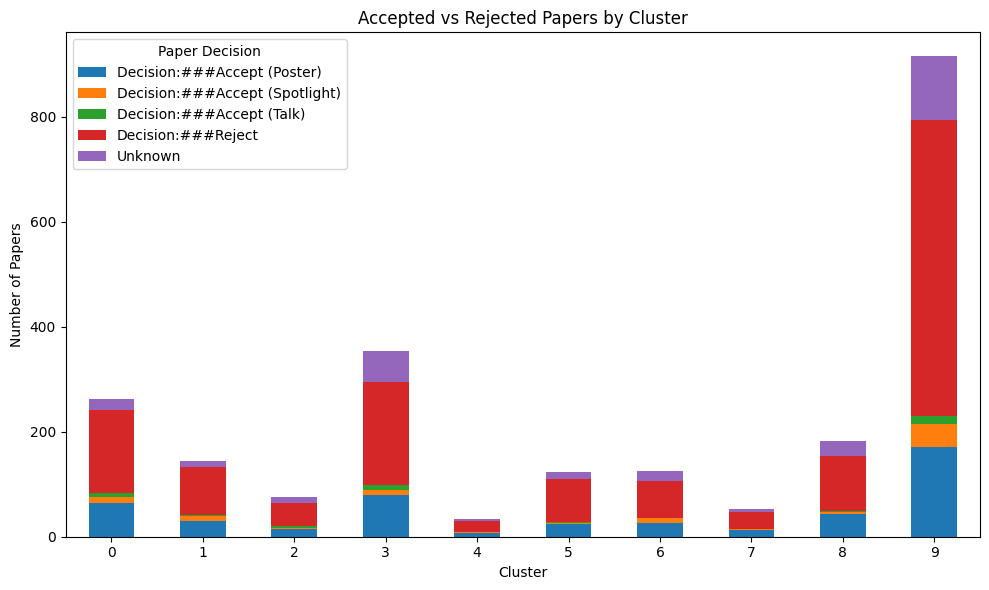

In [11]:
# Ensure there are no NaN values in the 'paper_decision' column
df['paper_decision'] = df['paper_decision'].fillna('Unknown')

# Group by cluster and paper decision, then count the occurrences
decision_counts = df.groupby(['cluster', 'paper_decision']).size().unstack(fill_value=0)

# Plot the results to visualize which clusters have more accepted or rejected papers
decision_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Accepted vs Rejected Papers by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Papers")
plt.xticks(rotation=0)
plt.legend(title="Paper Decision", loc="upper left")
plt.tight_layout()
plt.show()


 ### Step 6:
 
 After splitting the keywords into individual components, we flattened the data so that each keyword appears in its own row. Finally, by counting the occurrences of each keyword, we identified the most common keywords, which provides insights into the dominant research themes. This process is important because it helps us pinpoint trends in academic research, understand the focus areas within the dataset, and guide future research directions. It also helps in better organizing and clustering research papers based on shared keywords.

In [12]:
# Remove the prefix 'Keywords:###' from the string
df['cleaned_keywords'] = df['keyword'].str.replace(r'^Keywords:###', '', regex=True)

# Convert all keywords to lowercase to avoid case-sensitive differences
df['cleaned_keywords'] = df['cleaned_keywords'].str.lower()

# Split the keywords by comma and optional spaces, using proper escaping for the regex
df['keywords_list'] = df['cleaned_keywords'].str.split(r',\s*')

# Flatten the list of keywords so each keyword appears in a separate row
keywords_flat = df['keywords_list'].explode()

# Count how many times each keyword appears
keyword_counts = keywords_flat.value_counts()

# Get the most common keyword and its count
most_common_keyword = keyword_counts.idxmax()
most_common_count = keyword_counts.max()

# Print the most common keyword and the count of occurrences
print(f"The most common keyword is: '{most_common_keyword}'")
print(f"Number of papers with this keyword: {most_common_count}")


The most common keyword is: 'deep learning'
Number of papers with this keyword: 296


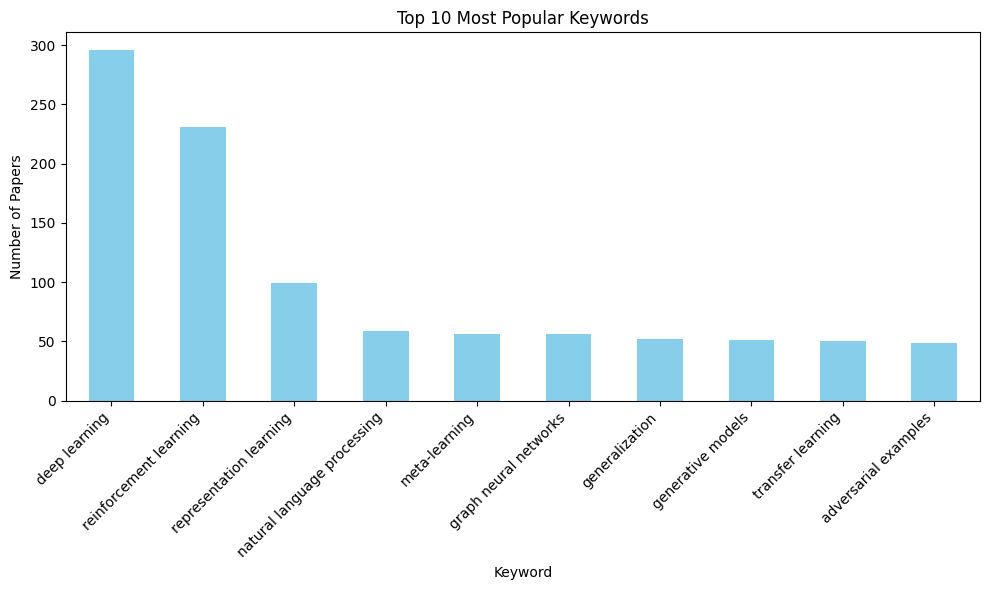

In [13]:
# Create a bar chart for the top N keywords
top_n = 10
top_keywords = keyword_counts.head(top_n)

plt.figure(figsize=(10, 6))
top_keywords.plot(kind='bar', color='skyblue')
plt.title(f"Top {top_n} Most Popular Keywords")
plt.xlabel("Keyword")
plt.ylabel("Number of Papers")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Step 7:

Sentiment analysis is a valuable technique for understanding the emotional tone and overall sentiment conveyed in textual data, such as abstracts and reviews. By analyzing the sentiment of the `abstract` and `review` columns in the dataset, we can uncover trends and correlations that might not be immediately obvious. For example, sentiment analysis of abstracts can reveal whether papers with more positive or neutral language tend to receive higher scores or are more likely to be accepted. Similarly, analyzing the sentiment of reviewer comments can help determine whether the tone of a review is correlated with the paper’s decision. This approach can provide additional insights into how the quality of papers, as well as reviewer feedback, is perceived and whether there are biases based on the language used. By applying sentiment analysis, we can enhance our understanding of the relationship between the textual content of papers and their outcomes in terms of decisions and ratings, allowing for more nuanced insights and potential improvements in the review process.

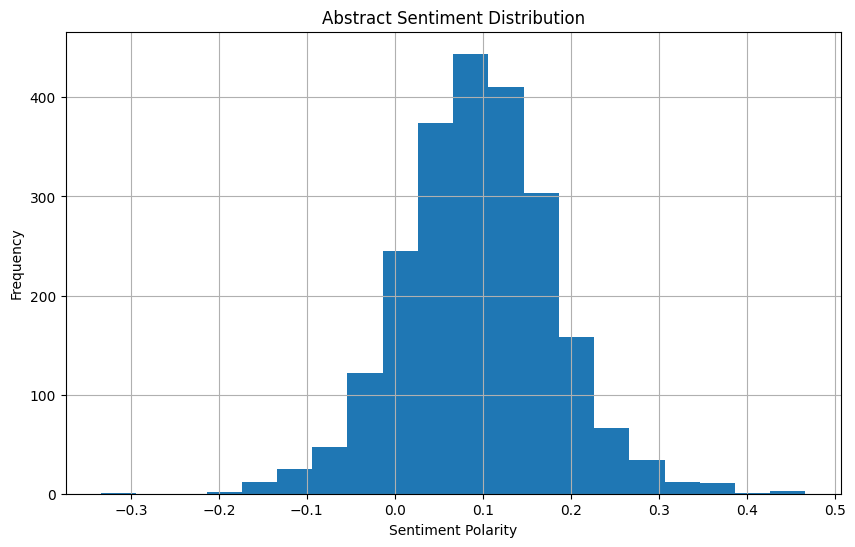

In [14]:
df['abstract_sentiment'] = df['abstract'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['abstract_sentiment'].hist(bins=20, figsize=(10, 6))
plt.title("Abstract Sentiment Distribution")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()

### Step 8:

This analysis was conducted to investigate whether a reviewer’s level of experience influences their decision to accept or reject a paper. To achieve this, we categorized reviewers based on their self-assessed experience levels and then examined the relationship between these levels and the decisions they made (Accept/Reject) using statistical methods such as the chi-squared test and logistic regression. Understanding this relationship is important for ensuring fairness and consistency in the peer-review process. If certain levels of reviewer experience are systematically associated with more rejections or acceptances, it could indicate bias or inconsistency that might impact the integrity of academic evaluations. Identifying such patterns can help conference organizers and journal editors make informed decisions about reviewer assignment and training, ultimately improving the quality and fairness of the review process.

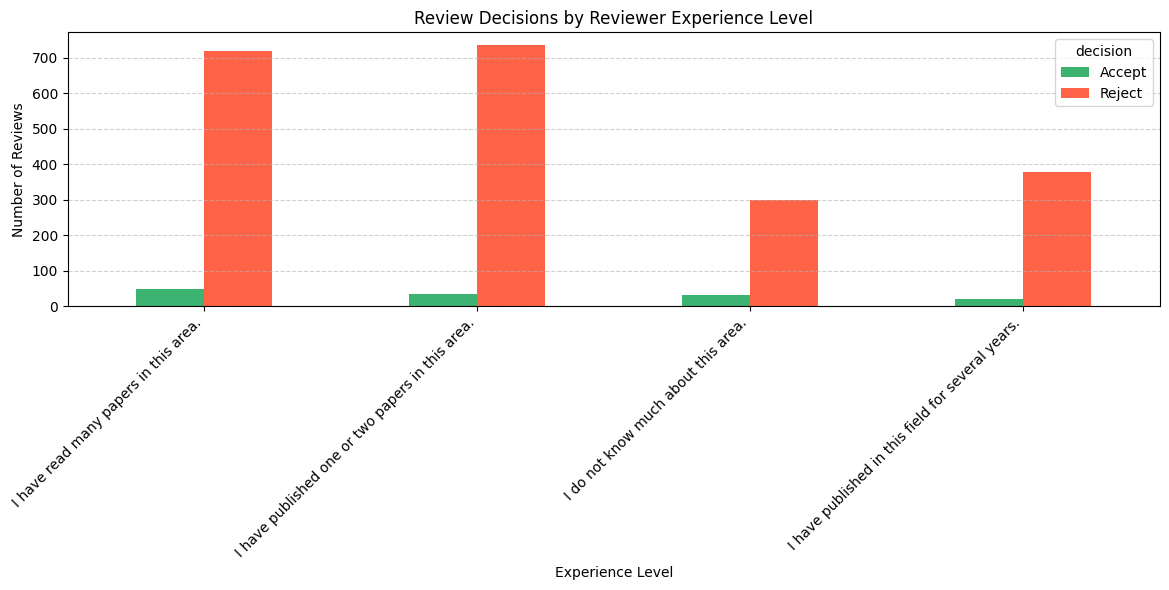

In [15]:
# Clean reviewer_level text
df['reviewer_level_clean'] = df['reviewer_level'].str.replace('Experience Assessment:###', '', regex=False).apply(lambda x: x.strip())

# Categorize rate into Accept/Reject
df['decision'] = df['rate'].apply(lambda x: 'Accept' if x >= 6 else 'Reject')
grouped = df.groupby(['reviewer_level_clean', 'decision']).size().unstack(fill_value=0)

# Sort by number of Accepts
grouped = grouped.sort_values(by='Accept', ascending=False)

grouped.plot(kind='bar', stacked=False, figsize=(12, 6), color=['mediumseagreen', 'tomato'])
plt.title("Review Decisions by Reviewer Experience Level")
plt.ylabel("Number of Reviews")
plt.xlabel("Experience Level")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [16]:
# Chi-squared test for independence
chi2, p, dof, expected = chi2_contingency(grouped)

print("Chi-squared Test:")
print(f"chi2 = {chi2:.2f}, p-value = {p:.4f}")
if p < 0.05:
    print("! There is a statistically significant association between reviewer experience and decision.")
else:
    print("No statistically significant association at the 5% level.")

# Check class imbalance
print("\nClass distribution:")
print(df['decision'].value_counts())

# One-hot encoding for reviewer_level
X = df[['reviewer_level_clean']]
y = df['decision'].apply(lambda x: 1 if x == 'Accept' else 0)  # 1 = Accept, 0 = Reject

encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X).toarray()

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train logistic regression with class balancing
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation 
print("\nLogistic Regression with Class Balancing:")
print(classification_report(y_test, y_pred, target_names=['Reject', 'Accept']))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# Interpretation of coefficients
feature_names = [name.replace('reviewer_level_clean_', '') for name in encoder.get_feature_names_out(['reviewer_level_clean'])]
coef_df = pd.DataFrame({
    'Experience': feature_names,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nEffect of Reviewer Experience on Acceptance Probability:")
print(coef_df)

Chi-squared Test:
chi2 = 12.74, p-value = 0.0052
! There is a statistically significant association between reviewer experience and decision.

Class distribution:
decision
Reject    2132
Accept     138
Name: count, dtype: int64

Logistic Regression with Class Balancing:
              precision    recall  f1-score   support

      Reject       0.94      0.50      0.65       420
      Accept       0.09      0.62      0.16        34

    accuracy                           0.51       454
   macro avg       0.52      0.56      0.40       454
weighted avg       0.88      0.51      0.61       454

Confusion matrix:
[[209 211]
 [ 13  21]]

Effect of Reviewer Experience on Acceptance Probability:
                                          Experience  Coefficient
0                I do not know much about this area.     0.453413
3              I have read many papers in this area.     0.071053
1  I have published in this field for several years.    -0.229245
2   I have published one or two papers 

### Step 9:

Understanding correlations between the review rating (rate), review content length (review_contentlength), and reviewer experience (reviewer_level) is crucial for improving the fairness and effectiveness of the peer review process. For example, if a significant correlation is found between the length of the review and the rating given, it could suggest that longer, more detailed reviews influence a reviewer's decision to accept or reject a paper. Similarly, examining how reviewer experience correlates with ratings can help identify potential biases or inconsistencies in the evaluation process. This analysis helps uncover patterns that can be used to refine reviewer selection and training, ensuring that the peer review process is more transparent, consistent, and reliable. By understanding these dynamics, conference organizers and journal editors can improve the quality of academic evaluations and reduce the impact of biases that might affect the acceptance of papers.

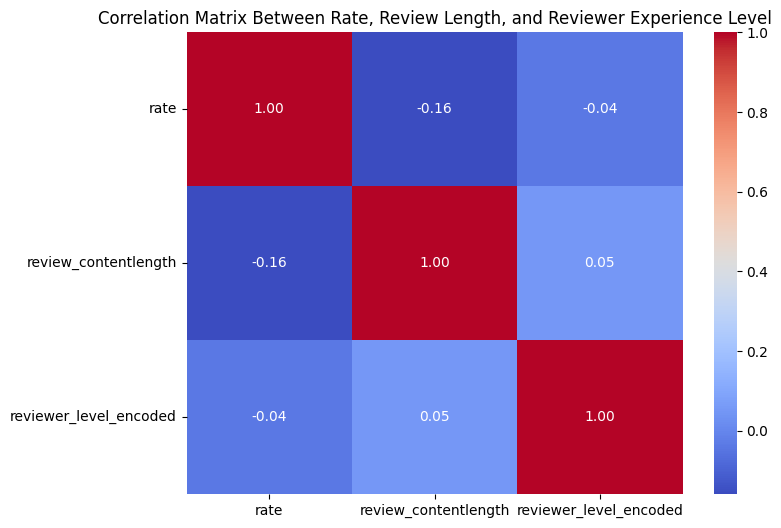


Correlation values:
                            rate  review_contentlength  reviewer_level_encoded
rate                    1.000000             -0.158947               -0.040691
review_contentlength   -0.158947              1.000000                0.050969
reviewer_level_encoded -0.040691              0.050969                1.000000


In [17]:
# Encode reviewer_level
encoder = LabelEncoder()
df['reviewer_level_encoded'] = encoder.fit_transform(df['reviewer_level_clean'])

# Calculate the correlation between 'rate', 'review_contentlength', and 'reviewer_level_encoded'
correlation_data = df[['rate', 'review_contentlength', 'reviewer_level_encoded']].corr()

# Visualizing the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Matrix Between Rate, Review Length, and Reviewer Experience Level")
plt.show()

print("\nCorrelation values:")
print(correlation_data)